# Standalone LoRA for Koopman Operator Learning - Demo

This notebook demonstrates how to use the standalone LoRA implementation extracted from NeuralKoopmanSVD.

**Reference:** Jeong et al., "Efficient Parametric SVD of Koopman Operator for Stochastic Dynamical Systems", NeurIPS 2025.

## Overview

- **What is LoRA?** Low-Rank Approximation for learning Koopman operators
- **Key Idea:** Learn feature functions φ(x) such that K·φ(x_t) ≈ φ(x_{t+1})
- **Advantage:** No matrix inversions or SVD needed during training

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from deepkoop_func import get_device
from tqdm.notebook import tqdm  # progress bar
import random

def seed_everything(seed=42):
    """
    固定所有随机种子以确保结果可复现
    """
    # 1. Python 内置随机模块
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 禁止hash随机化

    # 2. Numpy
    np.random.seed(seed)

    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # 4. 确保算法的确定性 (CUDNN)
    # 这两行会牺牲一点点性能，但能确保卷积操作的可复现性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Import the standalone LoRA implementation
from standalone_lora import (
    NestedLoRALoss,
    KoopmanLoRAModel,
    train_koopman_lora,
    compute_koopman_spectrum
)

device = get_device(force_cpu=False)
device

device(type='mps')

## 1. Generate Training Data

We'll use two example dynamical systems:

### Example 1: Logistic Map (Chaotic System)
$$x_{t+1} = 4x_t(1 - x_t) + \text{noise}$$

### Example 2: 2D Nonlinear System
$$\begin{align}
x_1' &= \lambda x_1 \\
x_2' &= \mu x_2 + (\lambda^2 - \mu)x_1^2
\end{align}$$

Generating Logistic Map data...
Training data: X shape = (5000, 1), Y shape = (5000, 1)
Test data: X shape = (1000, 1), Y shape = (1000, 1)


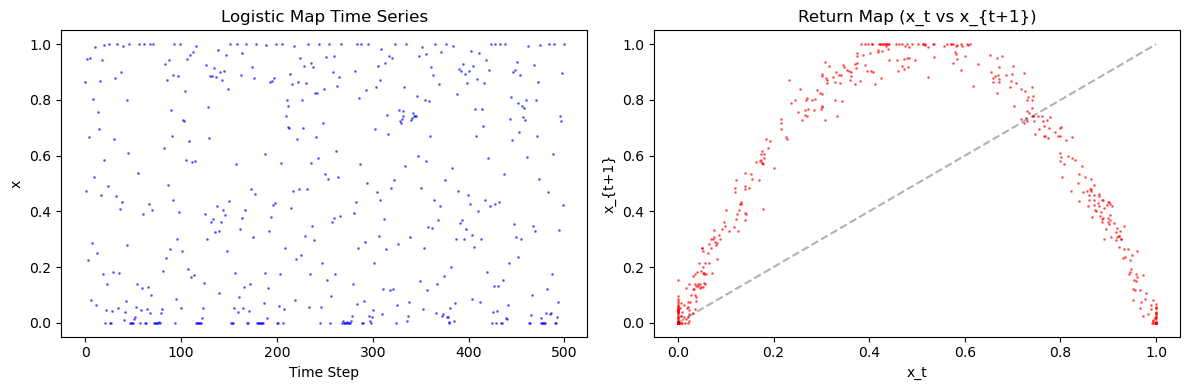

In [39]:
# ============================================================
# Choose which system to use: 'logistic' or '2d_nonlinear'
# ============================================================
SYSTEM_TYPE = 'logistic'  # or '2d_nonlinear'

# ============================================================
# Example 1: Logistic Map
# ============================================================
def generate_logistic_map(n_samples=10000, noise_level=0.05):
    """
    Generate noisy logistic map data.
    x_{t+1} = 4 * x_t * (1 - x_t) + noise
    """
    x = np.zeros(n_samples + 1)
    x[0] = np.random.rand()
    
    for t in range(n_samples):
        x_next = 4 * x[t] * (1 - x[t])
        noise = np.random.normal(0, noise_level)
        x[t+1] = np.clip(x_next + noise, 0, 1)
    
    X = x[:-1].reshape(-1, 1)
    Y = x[1:].reshape(-1, 1)
    return X, Y

# ============================================================
# Example 2: 2D Nonlinear System
# ============================================================
def step_2d_system(state, lam=0.9, mu=0.5):
    """Single step evolution."""
    x1, x2 = state[0], state[1]
    y1 = lam * x1
    y2 = mu * x2 + (lam**2 - mu) * (x1**2)
    return np.array([y1, y2])

def generate_2d_trajectories(n_trajectories=100, steps_per_traj=100, lam=0.9, mu=0.5):
    """
    Generate multiple trajectories of the 2D system.
    """
    X_list = []
    Y_list = []
    
    for _ in range(n_trajectories):
        state = np.random.uniform(-1, 1, 2)
        trajectory = [state]
        
        for _ in range(steps_per_traj - 1):
            state = step_2d_system(state, lam, mu)
            trajectory.append(state)
        
        trajectory = np.array(trajectory)
        X_list.append(trajectory[:-1])
        Y_list.append(trajectory[1:])
    
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    return X, Y

# ============================================================
# Generate data based on selected system
# ============================================================
if SYSTEM_TYPE == 'logistic':
    print("Generating Logistic Map data...")
    X_train, Y_train = generate_logistic_map(n_samples=5000, noise_level=0.05)
    X_test, Y_test = generate_logistic_map(n_samples=1000, noise_level=0.05)
    INPUT_DIM = 1
    
elif SYSTEM_TYPE == '2d_nonlinear':
    print("Generating 2D Nonlinear System data...")
    X_train, Y_train = generate_2d_trajectories(n_trajectories=100, steps_per_traj=100)
    X_test, Y_test = generate_2d_trajectories(n_trajectories=20, steps_per_traj=100)
    INPUT_DIM = 2

print(f"Training data: X shape = {X_train.shape}, Y shape = {Y_train.shape}")
print(f"Test data: X shape = {X_test.shape}, Y shape = {Y_test.shape}")

# Visualize the data
plt.figure(figsize=(12, 4))

if SYSTEM_TYPE == 'logistic':
    plt.subplot(1, 2, 1)
    plt.plot(X_train[:500], 'b.', alpha=0.5, markersize=2)
    plt.title('Logistic Map Time Series')
    plt.xlabel('Time Step')
    plt.ylabel('x')
    
    plt.subplot(1, 2, 2)
    plt.plot(X_train[:500], Y_train[:500], 'r.', alpha=0.5, markersize=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.title('Return Map (x_t vs x_{t+1})')
    plt.xlabel('x_t')
    plt.ylabel('x_{t+1}')
    
else:  # 2D system
    plt.subplot(1, 2, 1)
    for i in range(0, min(500, len(X_train)), 50):
        end_idx = min(i+50, len(X_train))
        plt.plot(X_train[i:end_idx, 0], X_train[i:end_idx, 1], 
                alpha=0.6, linewidth=1)
    plt.title('Phase Space Trajectories')
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(X_train[:500, 0], label='x_1')
    plt.plot(X_train[:500, 1], label='x_2')
    plt.title('Time Evolution')
    plt.xlabel('Time Step')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
seed_everything(seed=0)

训练集数据形状 (Trajs, Time, Dim): (100, 100, 2)
测试集数据形状 (Trajs, Time, Dim): (20, 100, 2)
------------------------------
转换后的 MLP 训练数据:
X_train: (9900, 2)
Y_train: (9900, 2)
------------------------------


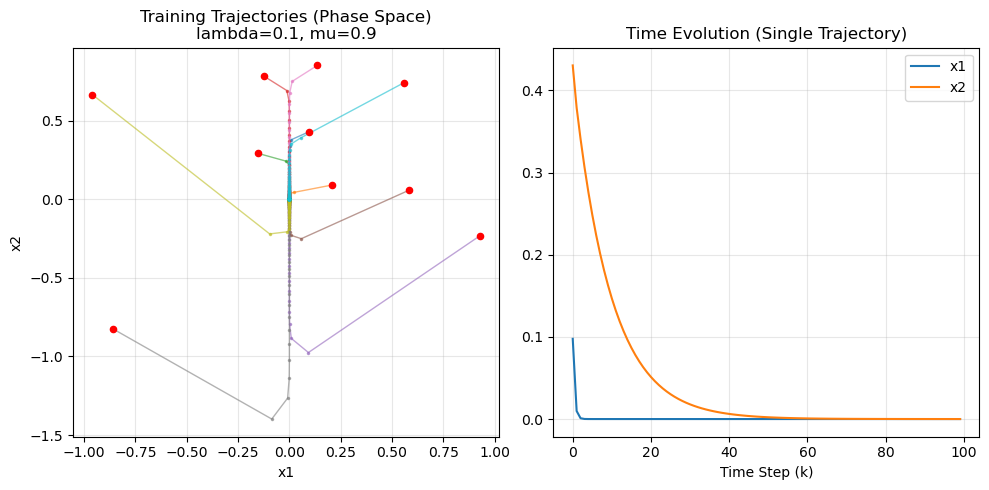

In [29]:
# 设置参数
LAMBDA = 0.1
MU = 0.9
BATCH_SIZE = 64

# --- 训练配置 ---
Sp = 30       # 训练时模型看多长？(预测步数)
seq_len_train = Sp + 1 # 实际切片长度需要多1个作为起始点

# --- 样本量配置 ---
# 为了让MLP拟合好，我们需要覆盖足够多的状态空间转换。
# 生成 100 条，每条 200 步的轨迹用于切片训练
N_TRAIN_TRAJS = 100
LEN_TRAIN_TRAJS = 100 

# 生成测试数据：需要更长的序列来验证长期稳定性
# 比如测试时想看 100 步的预测效果
STEP_TEST = 30 
N_TEST_TRAJS = 20     
LEN_TEST_TRAJS = STEP_TEST + 50 

def system_dynamics(state, lam=0.9, mu=0.5):
    """单步动力学演化"""
    x1, x2 = state[0], state[1]
    y1 = lam * x1
    y2 = mu * x2 + (lam**2 - mu) * (x1**2)
    return np.array([y1, y2])

# def system_dynamics(state, lam=0.8, mu=10):
#     """单步动力学演化"""
#     x1, x2 = state[0], state[1]
#     y1 = lam * x1 + mu * (x2**2)
#     y2 = lam * x2 
#     return np.array([y1, y2])

def generate_trajectories(num_trajectories, steps_per_traj, lam=0.9, mu=0.5, init_range=(-1, 1)):
    """
    生成多条长轨迹
    返回数据形状: (num_trajectories, steps_per_traj, 2)
    """
    # 预分配空间
    # 形状: [轨迹数, 时间步数, 状态维度]
    dataset = np.zeros((num_trajectories, steps_per_traj, 2))
    
    for i in range(num_trajectories):
        # 随机初始化起始点 x0
        current_state = np.random.uniform(init_range[0], init_range[1], 2)
        dataset[i, 0, :] = current_state
        
        # 迭代生成后续步
        for t in range(1, steps_per_traj):
            next_state = system_dynamics(current_state, lam, mu)
            dataset[i, t, :] = next_state
            current_state = next_state
            
    return dataset


train_trajectories = generate_trajectories(N_TRAIN_TRAJS, LEN_TRAIN_TRAJS, lam=LAMBDA, mu=MU)
test_trajectories = generate_trajectories(N_TEST_TRAJS, LEN_TRAIN_TRAJS, lam=LAMBDA, mu=MU)

print(f"训练集数据形状 (Trajs, Time, Dim): {train_trajectories.shape}") # (50, 200, 2)
print(f"测试集数据形状 (Trajs, Time, Dim): {test_trajectories.shape}")   # (10, 200, 2)

# --- 3. 数据转换 (为 MLP 训练做准备) ---
# MLP 通常需要 (x_t) -> (x_t+1) 的形式，或者滑动窗口 (x_t, x_t-1...) -> (x_t+1)
# 这里演示最简单的单步输入输出转换，将所有轨迹打平
def create_mlp_dataset(trajectories):
    X_list = []
    Y_list = []
    
    num_trajs, time_steps, dim = trajectories.shape
    
    for i in range(num_trajs):
        # 输入：从 t=0 到 t=T-1
        # 输出：从 t=1 到 t=T
        traj = trajectories[i]
        X_list.append(traj[:-1, :]) # Current state
        Y_list.append(traj[1:, :])  # Next state
        
    X_data = np.vstack(X_list)
    Y_data = np.vstack(Y_list)
    return X_data, Y_data

X_train, Y_train = create_mlp_dataset(train_trajectories)
X_test, Y_test = create_mlp_dataset(test_trajectories)

print("-" * 30)
print("转换后的 MLP 训练数据:")
print(f"X_train: {X_train.shape}") # 应为 (50 * 199, 2) = (9950, 2)
print(f"Y_train: {Y_train.shape}")
print("-" * 30)

# --- 可视化 ---
# 画出部分训练轨迹（相图 Phase Portrait）
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# 画前 10 条训练轨迹
for i in range(10):
    traj = train_trajectories[i]
    plt.plot(traj[:, 0], traj[:, 1], '.-', alpha=0.6, linewidth=1, markersize=3)
    # 标记起点
    plt.scatter(traj[0, 0], traj[0, 1], c='red', s=20, zorder=5)

plt.title(f"Training Trajectories (Phase Space)\nlambda={LAMBDA}, mu={MU}")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# 画第一条轨迹的时间演化 x1(t) 和 x2(t)
t_axis = np.arange(LEN_TRAIN_TRAJS)
plt.plot(t_axis, train_trajectories[0, :, 0], label='x1')
plt.plot(t_axis, train_trajectories[0, :, 1], label='x2')
plt.title("Time Evolution (Single Trajectory)")
plt.xlabel("Time Step (k)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Prepare DataLoaders

In [40]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.FloatTensor(Y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create dataloaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 20
Number of test batches: 4


## 3. Initialize Model and Loss Function

### Key Hyperparameters:

- **n_modes**: Number of Koopman modes (rank of approximation)
- **nesting**: Strategy for learning ordered singular functions
  - `'jnt'`: Joint nesting with progressive weighting (recommended)
  - `'seq'`: Sequential nesting with stop-gradients
  - `None`: No ordering guarantee
- **learn_svals**: Whether to learn singular values as parameters
- **has_centering**: Whether to fix the first singular value to 1.0

In [41]:
INPUT_DIM = 1
N_MODES = 5              # Number of Koopman modes
HIDDEN_DIMS = [64, 64]  # Hidden layer dimensions
NESTING = 'jnt'           # Nesting strategy: 'jnt', 'seq', or None
LEARN_SVALS = True        # Whether to learn singular values
HAS_CENTERING = True     # Whether to fix first singular value to 1.0
REG_WEIGHT = 0.0          # Regularization weight

# ============================================================
# Initialize Model
# ============================================================
model = KoopmanLoRAModel(
    input_dim=INPUT_DIM,
    n_modes=N_MODES,
    hidden_dims=HIDDEN_DIMS,
    activation='ELU',
    use_batchnorm=False,
    shared_encoder=False,
    learn_svals=LEARN_SVALS,
    has_centering=HAS_CENTERING,
)

# ============================================================
# Initialize Loss Function
# ============================================================
loss_fn = NestedLoRALoss(
    n_modes=N_MODES,
    nesting=NESTING,
    reg_weight=REG_WEIGHT,
)

# ============================================================
# Initialize Optimizer
# ============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Loss function: NestedLoRALoss with nesting='{NESTING}'")

Model initialized with 9230 parameters
Loss function: NestedLoRALoss with nesting='jnt'


## 4. Train the Model

In [42]:
# Train the model
N_EPOCHS = 100
LOG_INTERVAL = 10

print("Starting training...\n")
loss_history = train_koopman_lora(
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    optimizer=optimizer,
    device=device,
    n_epochs=N_EPOCHS,
    log_interval=LOG_INTERVAL,
)

print("\nTraining completed!")

Starting training...

Epoch [10/100], Loss: -1.068170
  Singular values: [1.         0.81178516 0.39417678 0.320523   0.27120322]
Epoch [20/100], Loss: -1.770119
  Singular values: [1.         0.81972307 0.39394107 0.31897098 0.27146813]
Epoch [30/100], Loss: -1.774628
  Singular values: [1.         0.8197697  0.39337668 0.3197477  0.27099556]
Epoch [40/100], Loss: -1.768948
  Singular values: [1.         0.8195464  0.39560002 0.33273515 0.27580726]
Epoch [50/100], Loss: -1.779968
  Singular values: [1.         0.81891    0.40131658 0.3371288  0.2760403 ]
Epoch [60/100], Loss: -1.774399
  Singular values: [1.        0.8182539 0.4068814 0.3343746 0.2746224]
Epoch [70/100], Loss: -1.775156
  Singular values: [1.         0.8176766  0.4095552  0.33232367 0.27525857]
Epoch [80/100], Loss: -1.785840
  Singular values: [1.         0.8176751  0.41498312 0.33447614 0.2792684 ]
Epoch [90/100], Loss: -1.781988
  Singular values: [1.         0.8173344  0.42090788 0.3405235  0.28927758]
Epoch [100/

## 5. Visualize Training Progress

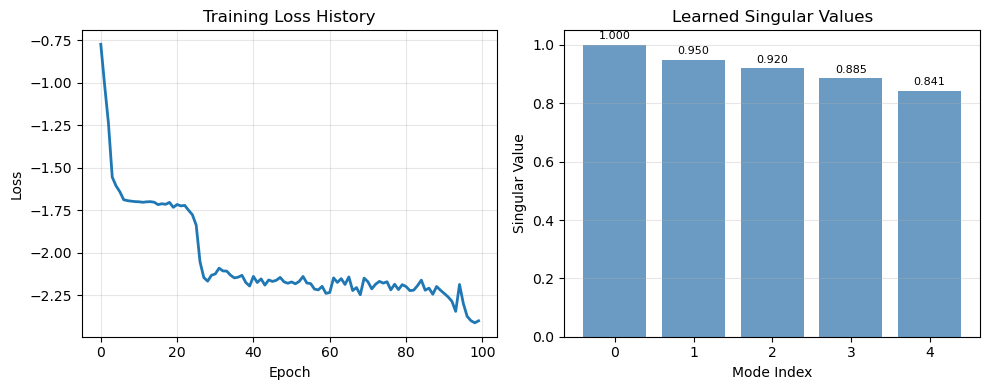

In [33]:
plt.figure(figsize=(10, 4))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(alpha=0.3)

# Plot learned singular values (if applicable)
if model.svals is not None:
    plt.subplot(1, 2, 2)
    svals = model.svals.detach().cpu().numpy()
    plt.bar(range(len(svals)), svals, color='steelblue', alpha=0.8)
    plt.xlabel('Mode Index')
    plt.ylabel('Singular Value')
    plt.title('Learned Singular Values')
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(svals):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## 6. Compute Koopman Spectrum

After training, we can compute:
- **Singular Values**: Importance of each mode
- **Eigenvalues**: Stability and oscillation frequencies
- **Koopman Matrix**: Linear operator in feature space

In [34]:
print("Computing Koopman spectrum...\n")
spectrum = compute_koopman_spectrum(model, test_loader, device)

print("Singular Values (top 5):")
print(spectrum['singular_values'][:5])
print("\nEigenvalues (top 5):")
print(spectrum['eigenvalues'][:5])

Computing Koopman spectrum...

Singular Values (top 5):
[0.9999772  0.99943733 0.9957683  0.99360436 0.39090195]

Eigenvalues (top 5):
[0.84926474+0.j 0.19191173+0.j 0.2680386 +0.j 1.4384302 +0.j
 1.348135  +0.j]


## 7. Visualize Results

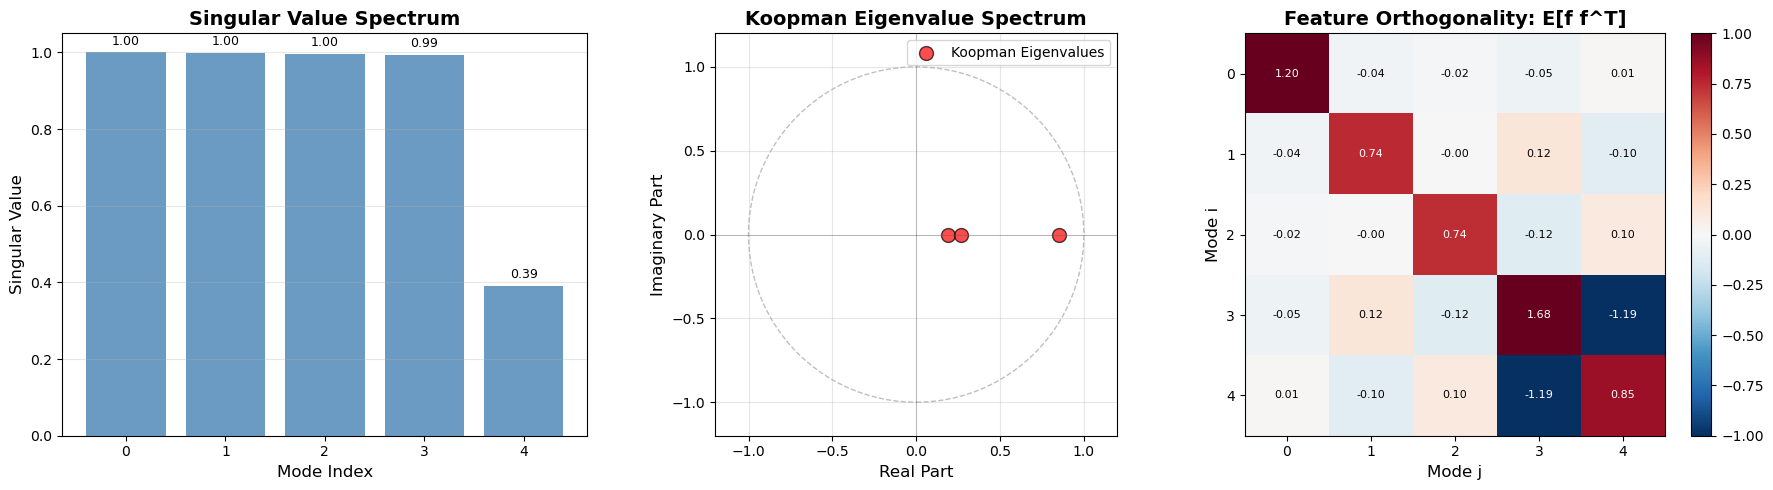

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ============================================================
# Plot 1: Singular Value Spectrum
# ============================================================
ax = axes[0]
svals = spectrum['singular_values']
ax.bar(range(len(svals)), svals, color='steelblue', alpha=0.8)
ax.set_xlabel('Mode Index', fontsize=12)
ax.set_ylabel('Singular Value', fontsize=12)
ax.set_title('Singular Value Spectrum', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(svals):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)

# ============================================================
# Plot 2: Eigenvalue Distribution (Complex Plane)
# ============================================================
ax = axes[1]
eigvals = spectrum['eigenvalues']

# Draw unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
ax.add_patch(circle)

# Plot eigenvalues
ax.scatter(eigvals.real, eigvals.imag, c='red', s=100, alpha=0.7, 
          edgecolors='black', linewidth=1, label='Koopman Eigenvalues')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('Real Part', fontsize=12)
ax.set_ylabel('Imaginary Part', fontsize=12)
ax.set_title('Koopman Eigenvalue Spectrum', fontsize=14, fontweight='bold')
ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
ax.axvline(0, color='k', linewidth=0.5, alpha=0.3)
ax.grid(alpha=0.3)
ax.legend()
ax.set_aspect('equal')

# ============================================================
# Plot 3: Feature Orthogonality (Moment Matrix)
# ============================================================
ax = axes[2]
M_f = spectrum['M_f']
im = ax.imshow(M_f, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xlabel('Mode j', fontsize=12)
ax.set_ylabel('Mode i', fontsize=12)
ax.set_title('Feature Orthogonality: E[f f^T]', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)

# Add text annotations
for i in range(min(N_MODES, M_f.shape[0])):
    for j in range(min(N_MODES, M_f.shape[1])):
        text_color = 'white' if abs(M_f[i, j]) > 0.5 else 'black'
        ax.text(j, i, f'{M_f[i, j]:.2f}', ha='center', va='center',
               color=text_color, fontsize=8)

plt.tight_layout()
plt.show()

## 8. Learned Feature Functions (For 1D Systems)

For 1D systems like the logistic map, we can visualize the learned feature functions.

In [36]:
if INPUT_DIM == 1:
    model.eval()
    
    # Create a grid of x values
    x_grid = torch.linspace(0, 1, 500).view(-1, 1).to(device)
    
    with torch.no_grad():
        features = model(x_grid, lagged=False).cpu().numpy()
    
    x_grid_np = x_grid.cpu().numpy()
    
    # Plot the learned feature functions
    n_plots = min(6, N_MODES)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(n_plots):
        ax = axes[i]
        ax.plot(x_grid_np, features[:, i], linewidth=2)
        ax.set_xlabel('State x', fontsize=11)
        ax.set_ylabel(f'φ_{i}(x)', fontsize=11)
        ax.set_title(f'Mode {i} (σ={spectrum["singular_values"][i]:.3f})', 
                    fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Learned Koopman Feature Functions', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()
else:
    print("Feature function visualization is only available for 1D systems.")

Feature function visualization is only available for 1D systems.


## 9. Model Prediction Test

Test the model's ability to predict future states using the learned Koopman operator.

In [37]:
model.eval()

# Take a few test samples
n_test_samples = 5
X_sample = X_test_tensor[:n_test_samples].to(device)
Y_true = Y_test_tensor[:n_test_samples].to(device)

with torch.no_grad():
    # Encode current state
    f_x = model(X_sample, lagged=False)
    
    # Apply Koopman operator in feature space
    K_matrix_torch = torch.tensor(spectrum['K_matrix'], dtype=torch.float32).to(device)
    f_y_pred = f_x @ K_matrix_torch.T
    
    # We can't directly decode back to state space without a decoder
    # But we can compare feature representations
    g_y_true = model(Y_true, lagged=True)
    
    # Compute prediction error in feature space
    feature_error = torch.mean((f_y_pred - g_y_true)**2).item()

print(f"Feature Space Prediction Error (MSE): {feature_error:.6f}")
print("\nNote: For full state-space prediction, you would need a decoder network.")
print("The current model operates in feature space only.")

Feature Space Prediction Error (MSE): 0.038686

Note: For full state-space prediction, you would need a decoder network.
The current model operates in feature space only.


## 10. Summary and Key Takeaways

### What We Learned:

1. **LoRA Loss**: Efficiently learns Koopman operators without matrix inversions
2. **Nesting Strategies**: 
   - Joint nesting (`'jnt'`) provides ordered singular functions
   - Sequential nesting (`'seq'`) uses stop-gradients
3. **Singular Values**: Learned values indicate mode importance
4. **Eigenvalues**: Show system stability (inside unit circle = stable)
5. **Feature Orthogonality**: M_f should be close to identity matrix

### Next Steps:

- Try different nesting strategies (`'jnt'` vs `'seq'` vs `None`)
- Experiment with different numbers of modes
- Test on your own dynamical systems
- Add a decoder network for full state-space reconstruction

### References:

- Jeong et al., "Efficient Parametric SVD of Koopman Operator for Stochastic Dynamical Systems", NeurIPS 2025
- GitHub: https://github.com/MinchanJeong/NeuralKoopmanSVD

In [38]:
print("="*70)
print("Demo completed successfully!")
print("="*70)

Demo completed successfully!
